In [6]:
# MSCI 546 Project:

# Link to the original Kaggle Competition (Real Dataset): https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction

In [7]:

# Libraries

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.optim as optim  # Optimization module

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [8]:
# Synthetic Dataset: https://www.kaggle.com/competitions/playground-series-s4e1/data

# Dataset import
import os
# Set directory to project root
os.chdir('/Users/danazarezankova/Documents/BME 2024/BME 4B/MSCI 546/msci-546-proj')

# Back to root directory
synthetic_train_data = pd.read_csv('data/train.csv')

synthetic_train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [9]:
synthetic_train_data.shape

(165034, 14)

In [10]:
# Label encoding for text data:
encoder = LabelEncoder()
categorical_features_train = synthetic_train_data.select_dtypes(include = 'object').columns
print("Categorical features: ", categorical_features_train)
for feature in categorical_features_train:
    synthetic_train_data[feature] = encoder.fit_transform(synthetic_train_data[feature])

# MinMax Scaler for credit score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
synthetic_train_data['CreditScore'] = scaler.fit_transform(synthetic_train_data[['CreditScore']])

# Robust Scaler for Balance
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
synthetic_train_data['Balance'] = scaler.fit_transform(synthetic_train_data[['Balance']])

# MinMax Scaler for Estimated Salary
scaler = MinMaxScaler()
synthetic_train_data['EstimatedSalary'] = scaler.fit_transform(synthetic_train_data[['EstimatedSalary']])

# Age / 100
synthetic_train_data['Age'] = synthetic_train_data['Age'] / 100

synthetic_train_data.drop('id', axis=1, inplace=True)
synthetic_train_data.drop('CustomerId', axis=1, inplace=True)
synthetic_train_data.drop('Surname', axis=1, inplace=True)
synthetic_train_data.dropna(inplace=True)

X = synthetic_train_data.drop('Exited', axis=1)
y = synthetic_train_data['Exited']


Categorical features:  Index(['Surname', 'Geography', 'Gender'], dtype='object')


In [11]:
X.describe()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,0.612909,0.648545,0.564429,0.381259,5.020353,0.462551,1.554455,0.753954,0.497770,0.562870
std,0.160207,0.816574,0.495833,0.088672,2.806159,0.523745,0.547154,0.430707,0.499997,0.251488
min,0.000000,0.000000,0.000000,0.180000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.494000,0.000000,0.000000,0.320000,3.000000,0.000000,1.000000,1.000000,0.000000,0.373166
50%,0.618000,0.000000,1.000000,0.370000,5.000000,0.000000,2.000000,1.000000,0.000000,0.589738
75%,0.720000,1.000000,1.000000,0.420000,7.000000,1.000000,2.000000,1.000000,1.000000,0.775779
max,1.000000,2.000000,1.000000,0.920000,10.000000,2.091872,4.000000,1.000000,1.000000,1.000000


In [12]:
# Convert the data to PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = nn.Sequential(
    nn.Linear(10, 20), # 8 input nodes to 12 nodes in the first hidden layer
    nn.ReLU(),        # ReLU activation for first hidden layer
    nn.Linear(20, 10), # 12 nodes from first hidden layer to 8 in the second
    nn.ReLU(),        # ReLU activation for second hidden layer
    nn.Linear(10, 1),  # 8 nodes from second hidden layer to 1 output node
    nn.Sigmoid()      # Sigmoid activation for output layer
)

In [15]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [16]:
n_epochs = 100
batch_size = 1028

train_accuracies = []

for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        y_pred = model(X)
        y_pred = y_pred.round().detach().numpy()
        accuracy = accuracy_score(y, y_pred)
        print(f'Epoch {epoch}, loss {loss}, accuracy {accuracy}')
        train_accuracies.append(accuracy)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Epoch 0, loss 0.4404769539833069, accuracy 0.7884011779390914
Finished epoch 0, latest loss 0.4404769539833069
Finished epoch 1, latest loss 0.4110754728317261
Finished epoch 2, latest loss 0.3804421126842499
Finished epoch 3, latest loss 0.3559440076351166
Finished epoch 4, latest loss 0.34220919013023376
Finished epoch 5, latest loss 0.3320968449115753
Finished epoch 6, latest loss 0.3253137469291687
Finished epoch 7, latest loss 0.3203427791595459
Finished epoch 8, latest loss 0.3169832229614258
Finished epoch 9, latest loss 0.3110458254814148
Epoch 10, loss 0.30850377678871155, accuracy 0.8573687846140795
Finished epoch 10, latest loss 0.30850377678871155
Finished epoch 11, latest loss 0.30681487917900085
Finished epoch 12, latest loss 0.3055306077003479
Finished epoch 13, latest loss 0.304864764213562
Finished epoch 14, latest loss 0.3041989505290985
Finished epoch 15, latest loss 0.3032965660095215
Finished epoch 16, latest loss 0.3023200035095215
Finished epoch 17, latest loss 0

In [17]:
with torch.no_grad():
  y_pred_test = model(X_test)
  y_pred_test = y_pred_test.round().detach().numpy()
  
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_test)

In [18]:
print(f'Accuracy of the shallow NN model: {accuracy}')

Accuracy of the shallow NN model: 0.8653618929318023


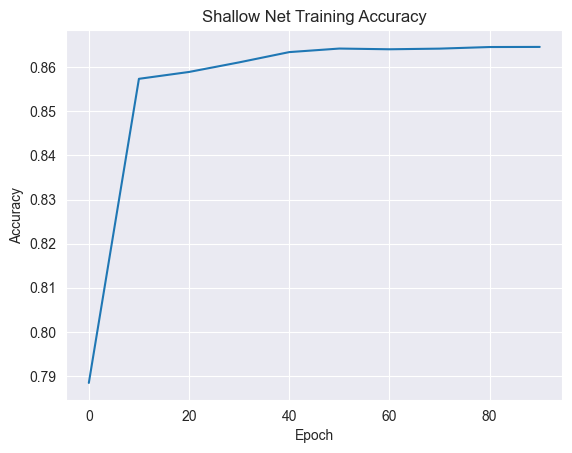

In [19]:
# Plot the training accuracy
plt.plot(range(0,100, 10), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Shallow Net Training Accuracy')
plt.show()

In [20]:
# Increase model width and depth

In [21]:
model = nn.Sequential(
    nn.Linear(10, 20), 
    nn.ReLU(),   
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),   
    nn.Linear(20, 10), 
    nn.ReLU(), 
    nn.Linear(10, 1), 
    nn.Sigmoid() 
)

In [22]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [23]:
n_epochs = 100
batch_size = 1028

train_accuracies = []

for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        y_pred = model(X)
        y_pred = y_pred.round().detach().numpy()
        accuracy = accuracy_score(y, y_pred)
        print(f'Epoch {epoch}, loss {loss}, accuracy {accuracy}')
        train_accuracies.append(accuracy)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Epoch 0, loss 0.3577733635902405, accuracy 0.8363791703527758
Finished epoch 0, latest loss 0.3577733635902405
Finished epoch 1, latest loss 0.31475120782852173
Finished epoch 2, latest loss 0.3066639006137848
Finished epoch 3, latest loss 0.30401843786239624
Finished epoch 4, latest loss 0.30197426676750183
Finished epoch 5, latest loss 0.3000074625015259
Finished epoch 6, latest loss 0.29915639758110046
Finished epoch 7, latest loss 0.2981194257736206
Finished epoch 8, latest loss 0.2980319559574127
Finished epoch 9, latest loss 0.2970236539840698
Epoch 10, loss 0.2959515452384949, accuracy 0.8622102112292013
Finished epoch 10, latest loss 0.2959515452384949
Finished epoch 11, latest loss 0.29606738686561584
Finished epoch 12, latest loss 0.29565781354904175
Finished epoch 13, latest loss 0.2976631820201874
Finished epoch 14, latest loss 0.2952112555503845
Finished epoch 15, latest loss 0.29783788323402405
Finished epoch 16, latest loss 0.30130821466445923
Finished epoch 17, latest l

In [24]:
with torch.no_grad():
  y_pred_test = model(X_test)
  y_pred_test = y_pred_test.round().detach().numpy()
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy of the deep NN model: {accuracy}')

Accuracy of the deep NN model: 0.8650892234980458


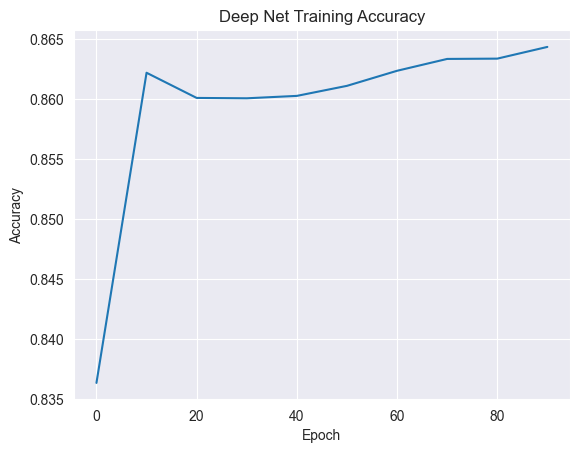

In [25]:
# Plot the training accuracy
plt.plot(range(0,100, 10), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Deep Net Training Accuracy')
plt.show()

In [26]:
# Add normalization to the model

model = nn.Sequential(
    nn.Linear(10, 20), 
    nn.BatchNorm1d(20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.BatchNorm1d(20),
    nn.ReLU(),   
    nn.Linear(20, 10),
    nn.BatchNorm1d(10),
    nn.ReLU(), 
    nn.Linear(10, 1), 
    nn.Sigmoid() 
)

In [27]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [28]:
n_epochs = 100
batch_size = 1028

train_accuracies = []

model.train()
for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        y_pred = model(X)
        y_pred = y_pred.round().detach().numpy()
        accuracy = accuracy_score(y, y_pred)
        print(f'Epoch {epoch}, loss {loss}, accuracy {accuracy}')
        train_accuracies.append(accuracy)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Epoch 0, loss 0.32889673113822937, accuracy 0.8562538628403844
Finished epoch 0, latest loss 0.32889673113822937
Finished epoch 1, latest loss 0.30561691522598267
Finished epoch 2, latest loss 0.2980937361717224
Finished epoch 3, latest loss 0.29533857107162476
Finished epoch 4, latest loss 0.2956080436706543
Finished epoch 5, latest loss 0.294033408164978
Finished epoch 6, latest loss 0.2934280335903168
Finished epoch 7, latest loss 0.2924134433269501
Finished epoch 8, latest loss 0.2924225330352783
Finished epoch 9, latest loss 0.2924652397632599
Epoch 10, loss 0.29260680079460144, accuracy 0.8639371281069356
Finished epoch 10, latest loss 0.29260680079460144
Finished epoch 11, latest loss 0.29227301478385925
Finished epoch 12, latest loss 0.29305970668792725
Finished epoch 13, latest loss 0.29334813356399536
Finished epoch 14, latest loss 0.2934405505657196
Finished epoch 15, latest loss 0.2928094267845154
Finished epoch 16, latest loss 0.29222914576530457
Finished epoch 17, latest 

In [29]:
with torch.no_grad():
  y_pred_test = model(X_test)

y_pred_50 = y_pred_test.round().detach().numpy()
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_50)
print(f'Accuracy of the deep NN model with normalization (50% threshold): {accuracy}')

Accuracy of the deep NN model with normalization (50% threshold): 0.8670585027418426


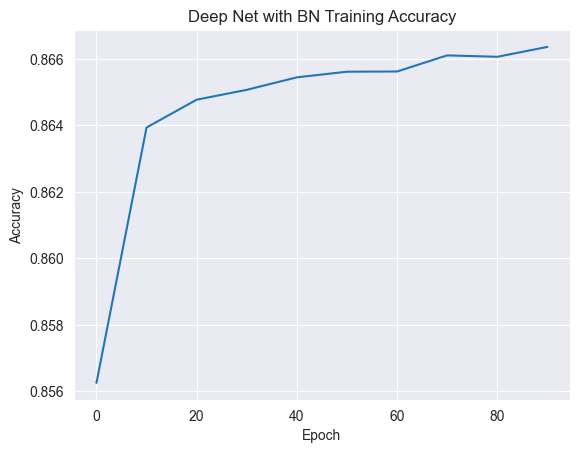

In [30]:
# Plot the training accuracy
plt.plot(range(0,100, 10), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Deep Net with BN Training Accuracy')
plt.show()

In [32]:
# Train for 500 epochs to see when the model converges
# Add normalization to the model

model = nn.Sequential(
    nn.Linear(10, 20), 
    nn.BatchNorm1d(20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.BatchNorm1d(20),
    nn.ReLU(),   
    nn.Linear(20, 10),
    nn.BatchNorm1d(10),
    nn.ReLU(), 
    nn.Linear(10, 1), 
    nn.Sigmoid() 
)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

n_epochs = 500
batch_size = 1028

train_accuracies = []

model.train()
for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        y_pred = model(X)
        y_pred = y_pred.round().detach().numpy()
        accuracy = accuracy_score(y, y_pred)
        print(f'Epoch {epoch}, loss {loss}, accuracy {accuracy}')
        train_accuracies.append(accuracy)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Epoch 0, loss 0.3092770576477051, accuracy 0.8598349431026334
Finished epoch 0, latest loss 0.3092770576477051
Finished epoch 1, latest loss 0.30685722827911377
Finished epoch 2, latest loss 0.30463752150535583
Finished epoch 3, latest loss 0.2993071675300598
Finished epoch 4, latest loss 0.29759469628334045
Finished epoch 5, latest loss 0.29826590418815613
Finished epoch 6, latest loss 0.29550299048423767
Finished epoch 7, latest loss 0.2952840328216553
Finished epoch 8, latest loss 0.29322904348373413
Finished epoch 9, latest loss 0.29200705885887146
Epoch 10, loss 0.29145029187202454, accuracy 0.865021753093302
Finished epoch 10, latest loss 0.29145029187202454
Finished epoch 11, latest loss 0.2899089455604553
Finished epoch 12, latest loss 0.2905634343624115
Finished epoch 13, latest loss 0.2908450663089752
Finished epoch 14, latest loss 0.2900119125843048
Finished epoch 15, latest loss 0.2896478772163391
Finished epoch 16, latest loss 0.2886308431625366
Finished epoch 17, latest l

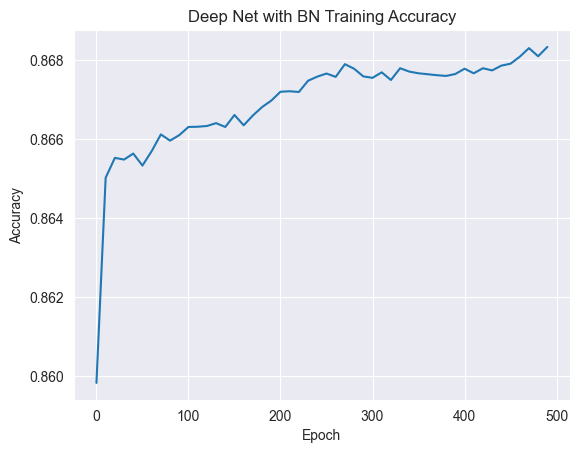

In [41]:
# Plot train accuracies
plt.plot(range(0,500, 10), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Deep Net with BN Training Accuracy')
plt.show()

In [33]:
with torch.no_grad():
  y_pred_test = model(X_test)

y_pred_50 = y_pred_test.round().detach().numpy()
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_50)
print(f'Accuracy of the deep NN model with normalization (50% threshold): {accuracy}')

Accuracy of the deep NN model with normalization (50% threshold): 0.8681491804768685


AUC:  0.8987210090133287
Precision:  0.7483304712841061
Recall:  0.5639108554996406


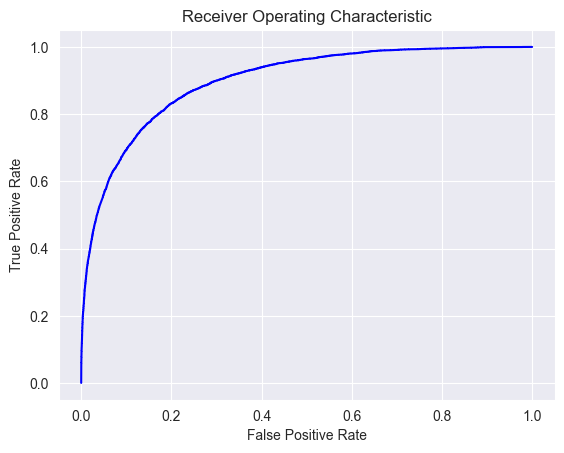

In [40]:
# Making the AUROC curve
import sklearn.metrics as metrics

tpr, fpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=0)
roc_auc = metrics.auc(fpr, tpr)
print("AUC: ", roc_auc)

# Precision and recall:
precision = metrics.precision_score(y_test, y_pred_50)
recall = metrics.recall_score(y_test, y_pred_50)
print("Precision: ", precision)
print("Recall: ", recall)

# Plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


Text(0.5, 427.9555555555555, 'Predicted label')

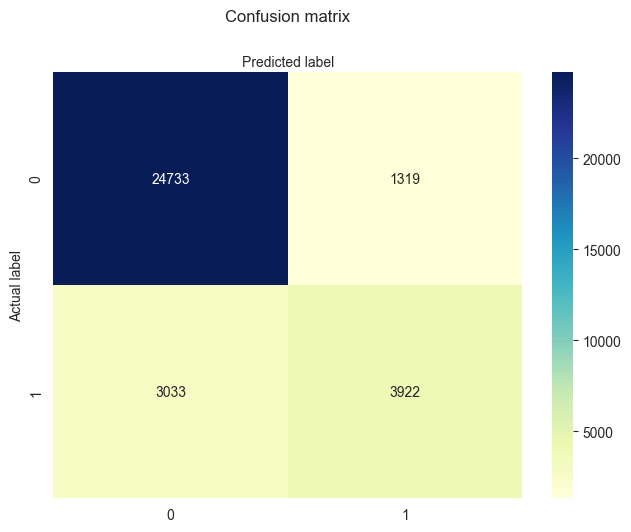

In [35]:
import sklearn.metrics as metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_50)

class_names=[0,1] # Names of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')